In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
import librosa

# 0. Disclaimer
- The purpose of this notebook is to experiment with the model and how the inputs are derived and not maximum performance, so only a small part of the dataset is used. i.e. the 1st fold

# 1. Data Preprocessing and feature extraction
- Data Augmentation using time and pitch shifts on audio samples
- Paper uses time-frequency patches that are extracted from the log-scaled mel-spectrogram as input into the model.

## 1.1 Reading in data using librosa

In [7]:
home_dir = "/content/drive/MyDrive/Urban Sound audio files/UrbanSound8K/"
metadata = pd.read_csv(home_dir+"metadata/UrbanSound8K.csv")
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [9]:
fold_1_metadata = metadata[metadata["fold"] == 1]

## 1.3. Data Augmentation
- Time-shifiting : [0.81, 0.93, 1.07, 1.23]
- Pitch-shifting I : [-2, -1, 1, 2]
- Pitch-shifting II : [-3.5, -2.5, 2.5, 3.5]

In [70]:
def augmentations(audio, sr, label):

    ts  = [ 0.81, 0.93, 1.07, 1.23]
    ps = [ -2, -1, 1, 2, -3.5, -2.5, 2.5, 3.5 ]

    out = {}
    for stretch in ts:
        name = ('ts{:.2f}'.format(stretch),label)
        out[name] = librosa.effects.time_stretch(audio, rate = stretch)

    for shift in ps:
        name = ('ps{:.2f}'.format(shift),label)
        out[name] = librosa.effects.pitch_shift(audio, sr = sr, n_steps = shift)

    return out

In [39]:
def file_parser(file_name):
  wave,sr = librosa.load(home_dir+"audio/fold1/"+file_name)
  return wave,sr

# Testing the function
# wave, sr = librosa.load(home_dir+"audio/fold1/"+fold_1_metadata.iloc[0].slice_file_name,sr = 44010)
# # Output is 12 different augmented variations of the original wave
# output = augmentations(wave,sr)
# len(output.keys())

## 1.4. Extracting log-scaled mel spectrogram using librosa

In [47]:
# These parameters are the same ones used in Sound Classification with constrained resources paper
from librosa.feature import melspectrogram
settings = {}
settings["n_mels"] = 128
settings["n_fft"] = 1024
settings["hop_length"] = 512
settings["fmin"] = 0
settings["fmax"] = 22050


def compute_mels(y, sr, settings):
    mels = melspectrogram(y=y, sr=sr,
                         n_mels=settings['n_mels'],
                         n_fft=settings['n_fft'],
                         hop_length=settings['hop_length'],
                         fmin=settings['fmin'],
                         fmax=settings['fmax'])
    mels_dB = librosa.power_to_db(mels, ref=np.max)
    return mels_dB

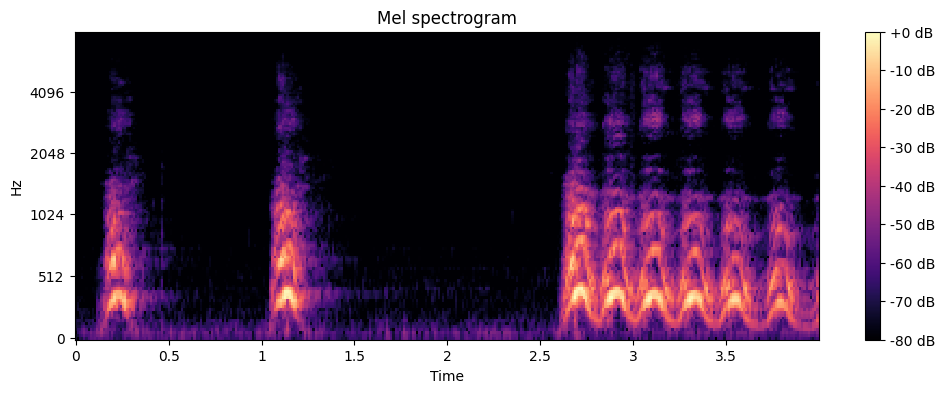

In [48]:
# Testing the function
# import matplotlib.pyplot as plt
# wave,sr = librosa.load(home_dir+"audio/fold1/"+fold_1_metadata.iloc[0].slice_file_name,sr = 44010)
# mel_matrix = compute_mels(wave,sr,settings)
# # 128 Mel Bands and 173 FFT windows (taken from original wave length, window length and hop_size)
# # mel_matrix.shape
# # Display Mel Spectrogram
# plt.figure(figsize=(12, 4))
# librosa.display.specshow(mel_matrix, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel spectrogram')
# plt.show()

## 1.5. Getting the TF patches
- The process is to split each Mel-Spectrogram into random 3s TF patches.

In [65]:
# Data Augmentation --> Log scaled Mel-spectrogram --> TF patches
# Sample rate = 44010(Hz), sample period = 1/44010(s), FFT_window_period = 1024*1/44010 (s), n_FFT_windows = 173
# To get 3s patches, choose random start points with 128(round down to be consistent with the paper) FFT windows
# Split column wise as mel_matrix, freq*time

# The paper randomly picks a start index, I assume that the TF_patch has no repeitions

# Output 128*128
def TF_patch(mel_matrix,start_index):
  splits = np.hsplit(mel_matrix,np.array([start_index,start_index+128]))
  output = splits[1]
  return output

# To make sure that we only get valid samples without need for padding
def get_possible_starts(mel_matrix):
   time_axis = mel_matrix.shape[1]
   return [i for i in range(0,time_axis-128)]




# 1.6. Generating a single training instance

In [ ]:
# Two choices, I either start from the raw signal OR I generate mel-spectrograms of all the augmentations and sample from there
# The paper seems to generate all mel_spectrograms first
# fold1 has 873 samples --> after augmentation 873*12 = 10476 total new audio files --> 10476 Mel-Spectrograms --> TF_patches


# 2. Baseline model architecture
- 3 Convolutional Layers
- 2 Dense Linear Layers

In [49]:
# Code heavily references the paper on Environmental Sound Classification on Microcontrollers using Convolutional Neural Networks
# To check for how many channels we have
frames=128 # Number of time frames we have
bands=128 # Number of Mel Bands
channels=1# Number of input channels, determines what kind of convolution we use
num_labels=10 # Number of audio target labels
conv_size=(5,5) # Size of each filter/kernel
conv_block='conv'
downsample_size=(4,2) # Stride size
fully_connected=64 # Dense layer number of neurons
n_stages=None
n_blocks_per_stage=None
filters=24
kernels_growth=2 # After each convolutional layer, the paper includes growth of filter
dropout=0.5
use_strides=False

Conv2 = SeparableConv2D if conv_block == 'depthwise_separable' else Convolution2D


kernel = conv_size # Size of each filter/kernel
if use_strides: # How much each filter moves
  strides = downsample_size
  pool = (1, 1)
else:
  strides = (1, 1)
  pool = downsample_size

# First Block assumes 2D Convolution i.e. input has one channel

block1 = [
  Convolution2D(filters, kernel, padding='same', strides=strides,
  input_shape=(bands, frames, channels)),
  BatchNormalization(),
  MaxPooling2D(pool_size=pool),
  Activation('relu'),
  ]


block2 = [
  Conv2(filters*kernels_growth, kernel, padding='same', strides=strides),
  BatchNormalization(),
           MaxPooling2D(pool_size=pool),
  Activation('relu'),
]

block3 = [
  Conv2(filters*kernels_growth, kernel, padding='valid', strides=strides),
  BatchNormalization(),
  Activation('relu'),
]

backend = [
  Flatten(),
  Dropout(dropout),
  Dense(fully_connected, kernel_regularizer=l2(0.001)),
  Activation('relu'),
  Dropout(dropout),
  Dense(num_labels, kernel_regularizer=l2(0.001)),
  Activation('softmax'),
]
layers = block1 + block2 + block3 + backend
model = Sequential(layers)

# Training the model
1. Training Procedure
- The model uses cross-entropy as loss function
- Uses mini-batch SGD with 100 TF-patches randomly selected from training data
- Predictions is the label with the highest mean prediction across each batch.


# Testing the model